In [112]:
library(adaptMCMC)
library(coda)
library(MASS)

In [113]:
mu.true <- 20
sigma.true <- 2
data <- rnorm(n=200, mean=mu.true, sd=sigma.true)

In [114]:
loglike1 <- function(params, data){
    return (sum(dnorm(data, mean=abs(params[1]), sd=params[2], log=TRUE)))
}

logprior1 <- function(params){
    return (dunif(params[1], min=-10000, max=10000, log=TRUE)+dunif(params[2], min=0, max=100, log=TRUE))
}

logpost1 <- function(params, data, temp){
    lp <- logprior1(params)
    if (is.infinite(lp)){
        return(-Inf)
    }
    ll <- loglike1(params, data)
    return (temp*(ll+lp))
}

In [115]:
loglike2 <- function(params, data){
    return (sum(dnorm(data, mean=abs(params), sd=2, log=TRUE)))
}

logprior2 <- function(params){
    return (dunif(params, min=-10000, max=10000, log=TRUE))
}

logpost2 <- function(params, data, temp){
    lp <- logprior2(params)
    if (is.infinite(lp)){
        return(-Inf)
    }
    ll <- loglike2(params, data)
    return (temp*(ll+lp))
}

In [116]:
temp.schedules <- function(nchains, deltaT){
    temps <- c()
    for (i in seq(1, nchains)){
        temps <- c(temps, 1/(1+deltaT*(i-1)))
    }
    return (temps)
}

In [227]:
repexMCMC <- function(nchains, temp_intervals, initials, logposterior, data, ncycles, cycle, covariance_matrix, nparams){
    ntrials <- 0
    nswaps <- 0
    output <- list()
    for (i in 1:nchains){
        output[[i]] <- list()
        output[[i]]$samples <- matrix(nrow=1+ncycles*cycle, ncol=nparams)
        output[[i]]$samples[1, ] <- initials[i, ]
        output[[i]]$log.p <- rep(0, 1+ncycles*cycle)
        output[[i]]$log.p[1] <- logposterior(initials[i, ], data, temp_intervals[i])
    }
    for (i in 1:ncycles){
        for (j in 1:cycle){
            index <- (i-1)*cycle+j
            for (k in 1:nchains){
                currentState <- output[[k]]$samples[index, ]
                currentLog.p <- output[[k]]$log.p[index]
                proposalState <- mvrnorm(n=1, mu=currentState, Sigma=covariance_matrix)
                proposalLog.p <- logposterior(proposalState, data, temp_intervals[k])
                P.accept <- min(0, proposalLog.p-currentLog.p)
                U <- runif(n=1, min=0, max=1)
                if (log(U) < P.accept){
                    output[[k]]$samples[index+1, ] <- proposalState
                    output[[k]]$log.p[index+1] <- proposalLog.p
                }
                else{
                    output[[k]]$samples[index+1, ] <- currentState
                    output[[k]]$log.p[index+1] <- currentLog.p
                }
            }
        }
        ntrials <- ntrials+1
        couple <- sample(1:nchains, size=2); c1 <- couple[1]; c2 <- couple[2]
        x <- output[[c1]]$samples[index+1, ]; y<- output[[c2]]$samples[index+1, ]
        P.swap <- min(0, logpost(y, data=data, temp=temp_intervals[c1])+
                         logpost(x, data=data, temp=temp_intervals[c2])-
                         logpost(x, data=data, temp=temp_intervals[c1])-
                         logpost(y, data=data, temp=temp_intervals[c2]))
        U <- runif(n=1, min=0, max=1)
        if (log(U) < P.swap){
            nswaps <- nswaps + 1
            output[[c1]]$samples[index+1, ] <- y; output[[c2]]$samples[index+1, ] <- x
        }
    }
    print (nswaps/ntrials)
    return (output[[1]])
}

[1] 0.42055


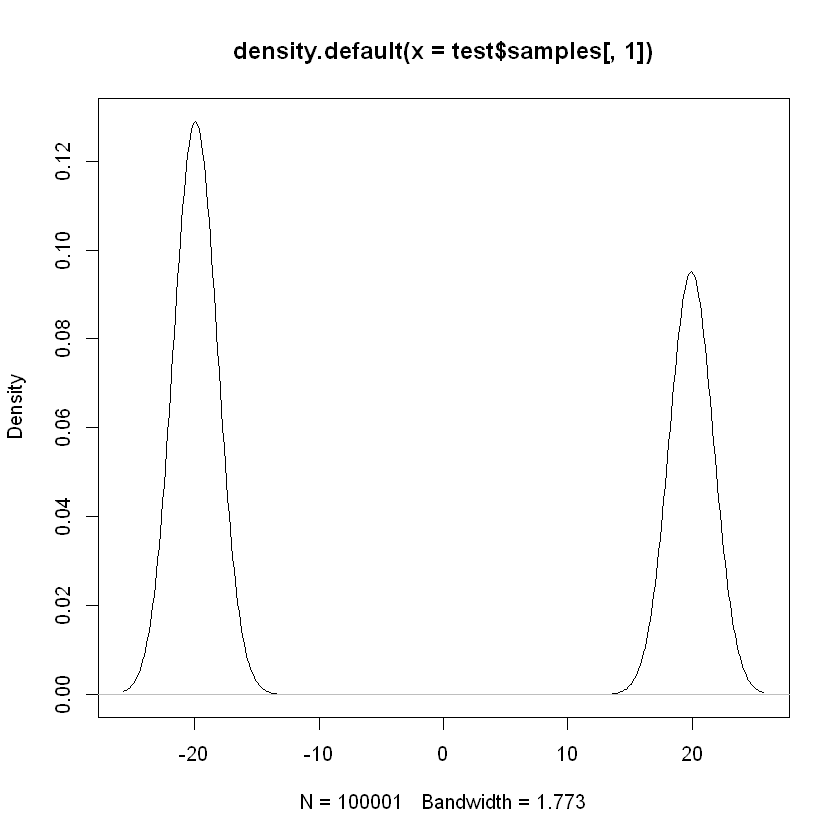

In [240]:
nchains <- 10
deltaT <- 2
temps <- temp.schedules(nchains, deltaT)
init <- 0
cov <- matrix(data=c(0,0), ncol=2, nrow=2)
cov[1,1] <- 1
cov[2,2] <- 1
test <- repexMCMC(10, temps, matrix(data=c(0, 1), ncol=2, nrow=10, byrow=TRUE), logpost1, data, 20000, 5, cov, 2)
d <- density(test$samples[, 1])
plot(d)

In [119]:
parallel.tempering <- function(nchains, temps, init, logpost, data, niter, scale){
    chains <- list()
    values <- list()
    nswaps <- 0
    for (i in seq(1, nchains)){
        chains[[i]] <- c(init)
        values[[i]] <- c(logpost(init, data=data, temp=temps[i]))
    }
    for (i in seq(1, niter)){
        for (j in seq(1, nchains)){
            currentValue <- values[[j]][i]
            currentState <- chains[[j]][i]
            nextState <- rnorm(1, mean=currentState, sd=scale)
            nextValue <- logpost(nextState, data=data, temp=temps[j])
            P.accept <- min(c(0, nextValue-currentValue))
            U <- runif(1, min=0, max=1)
            if (log(U) < P.accept){
                chains[[j]] <- c(chains[[j]], nextState)
                values[[j]] <- c(values[[j]], nextValue)
            }
            else{
                chains[[j]] <- c(chains[[j]], currentState)
                values[[j]] <- c(values[[j]], currentValue)
            }
        }
        swap.couple <- sample(seq(1, nchains), size=2)
        x <- chains[[swap.couple[1]]][i+1]
        y <- chains[[swap.couple[2]]][i+1]
        numerator <- logpost(y, data=data, temp=temps[swap.couple[1]])+logpost(x, data=data, temp=temps[swap.couple[2]])
        dominator <- -(logpost(x, data=data, temp=temps[swap.couple[1]])+logpost(y, data=data, temp=temps[swap.couple[2]]))
        P.swap <- min(c(0, numerator+dominator))
        U <- runif(1, min=0, max=1)
        if (log(U) < P.swap){
            nswaps <- nswaps + 1
            chains[[swap.couple[1]]][i+1] <- y
            chains[[swap.couple[2]]][i+1] <- x
        }
    }
    print(nswaps/niter)
    return (chains)
}

In [109]:
chains <- parallel.tempering(nchains, temps, 0, logpost2, data, 20000, 1)

[1] 0.27255


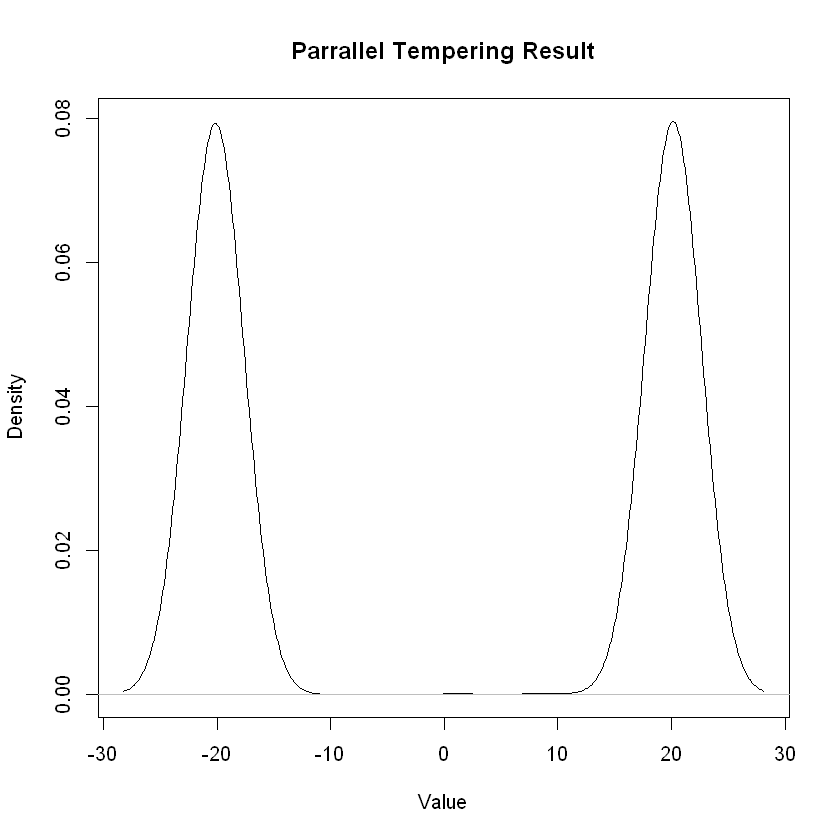

In [110]:
d <- density(chains[[1]])
plot(d, main='Parrallel Tempering Result', ylab='Density', xlab='Value')